In [79]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import re

from dataclasses import dataclass, field
from pathlib import Path

from copy import deepcopy

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# EBT3 data loading

In [80]:
#image_path = Path('C:\\Users\\Legion\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\2024-04-22\\skan108.npy')
image_path = project_dir / 'data' / 'raw' / '2024-04-22' / 'skan108.npy'
#image_path = Path('C:\\Users\\Legion\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\2024-04-22\\skan108.npy')
image_path.exists()

True

In [81]:
bg_r = 42804.451 
bg_g = 44273.485
bg_b = 27929.477 

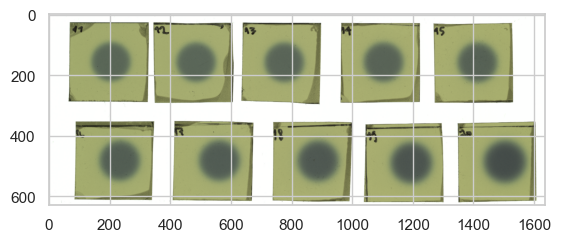

In [82]:
im = np.load(image_path)
im.shape, im.dtype
plt.imshow(im / im.max(), cmap='gray')

In [83]:
netOD = np.log10(bg_r / im[:,:,0])
netOD.min(), netOD.max()

(-0.18498437250366387, 0.8612261930909926)

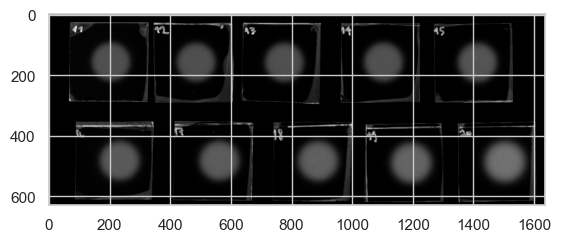

In [84]:
# plot as black areas where netOD is below 0
plt.imshow(np.where(netOD < 0, 0, netOD), cmap='gray')

## First foil selection

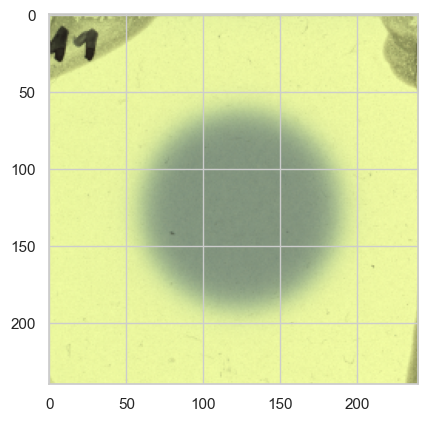

In [85]:
foil_11_init_center = (150, 200)
foil_11_init_dx = 120
foil_11_init_dy = 120
foil_11 = im[foil_11_init_center[0]-foil_11_init_dx:foil_11_init_center[0]+foil_11_init_dx,
             foil_11_init_center[1]-foil_11_init_dy:foil_11_init_center[1]+foil_11_init_dy]
plt.imshow(foil_11 / foil_11.max(), cmap='gray')

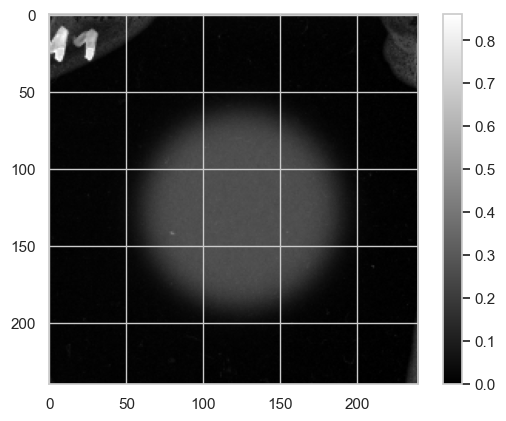

In [86]:
foil11_netOD = np.log10(bg_r / foil_11[:,:,0])
# clip negative values
foil11_netOD = np.clip(foil11_netOD, 0, None)
plt.imshow(foil11_netOD, cmap='gray')
plt.colorbar()

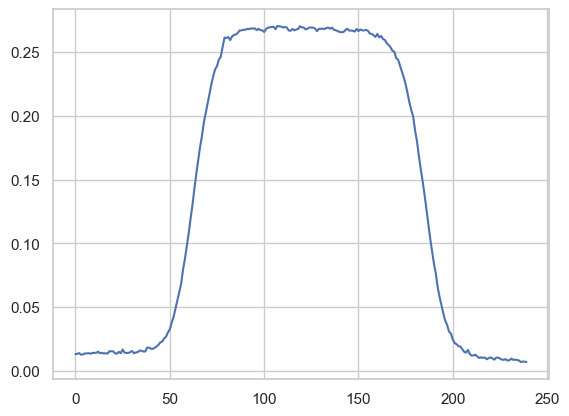

In [87]:
plt.plot(foil11_netOD[100:150,:].mean(axis=0))

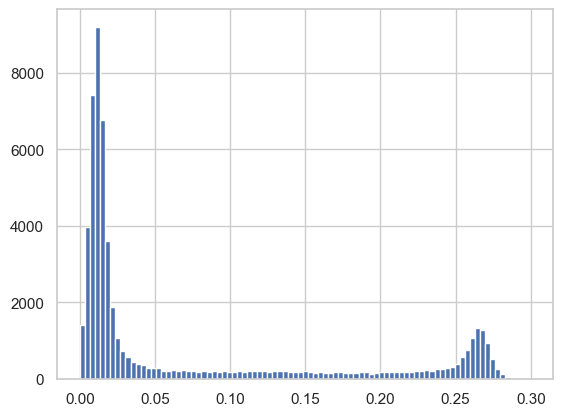

In [88]:
plt.hist(foil11_netOD.ravel(), bins=np.linspace(0, 0.3, 90));

# Calibration

In [141]:
@dataclass
class Calibration:
    a0 : float = 0
    a1 : float = 0
    a2 : float = 0
    a3 : float = 0

    def __call__(self, x):
        return self.a0 + self.a1*x + self.a2*x**2 + self.a3*x**3

    def __repr__(self):
        result = f'f(x) = '
        first_item = True
        if self.a0 != 0:
            result += f'{self.a0}'
            if first_item:
                first_item = False
            else:
                result += ' +'
        if self.a1 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a1}*x'
        if self.a2 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a2}*x^2'
        if self.a3 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a3}*x^3'
        return result

castrictioni = Calibration(a1=0.11, a3=40.7)
kusyk1 = Calibration(a0=166.55345, a1=-52.70907, a2=1)
kusyk2 = Calibration(a1=38.60467, a2=-147.36455, a3=242.49368)
kusyk3 = Calibration(a1=-6.14537, a3=131.76786)

In [142]:
netOD_test = 0.28
castricioni(netOD_test), kusyk1(netOD_test), kusyk2(netOD_test), kusyk3(netOD_test)

(0.9242464000000004, 151.87331039999998, 4.57914814336, 1.171864462720001)

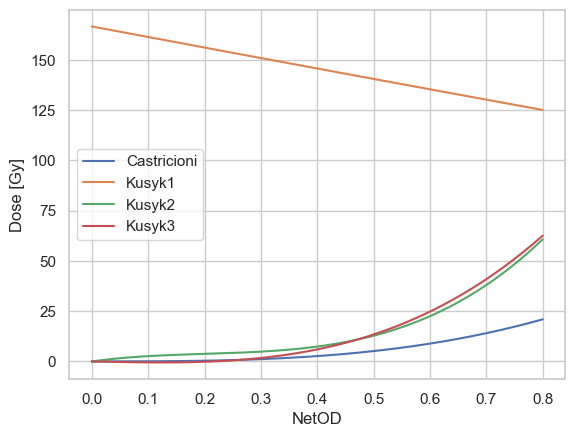

In [143]:
netOD_plot = np.linspace(0, 0.8, 800)

fig, ax = plt.subplots()
ax.plot(netOD_plot, castricioni(netOD_plot), label='Castricioni')
ax.plot(netOD_plot, kusyk1(netOD_plot), label='Kusyk1')
ax.plot(netOD_plot, kusyk2(netOD_plot), label='Kusyk2')
ax.plot(netOD_plot, kusyk3(netOD_plot), label='Kusyk3')
ax.set_xlabel('NetOD')
ax.set_ylabel('Dose [Gy]')
ax.legend()

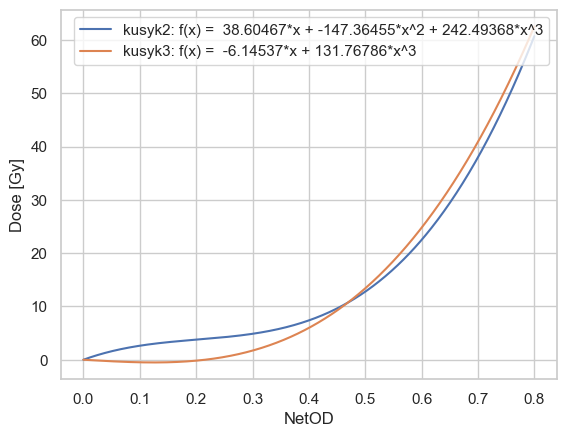

In [146]:
netOD_plot = np.linspace(0, 0.8, 800)

fig, ax = plt.subplots()
ax.plot(netOD_plot, kusyk2(netOD_plot), label=f'kusyk2: {kusyk2}')
ax.plot(netOD_plot, kusyk3(netOD_plot), label=f'kusyk3: {kusyk3}')
ax.set_xlabel('NetOD')
ax.set_ylabel('Dose [Gy]')
ax.legend()

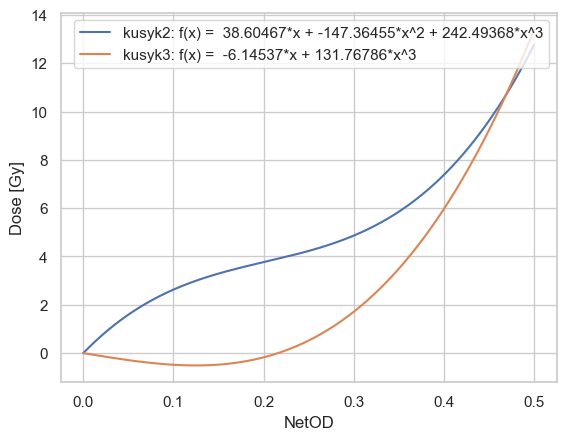

In [147]:
netOD_plot = np.linspace(0, 0.5, 1000)

fig, ax = plt.subplots()
ax.plot(netOD_plot, kusyk2(netOD_plot), label=f'kusyk2: {kusyk2}')
ax.plot(netOD_plot, kusyk3(netOD_plot), label=f'kusyk3: {kusyk3}')
ax.set_xlabel('NetOD')
ax.set_ylabel('Dose [Gy]')
ax.legend()

## Channels

In [13]:
od = np.log10(bg_g/foil_11[:,:,1].max())
13.42539*od+61.67447*od**3

-0.11615193194040435

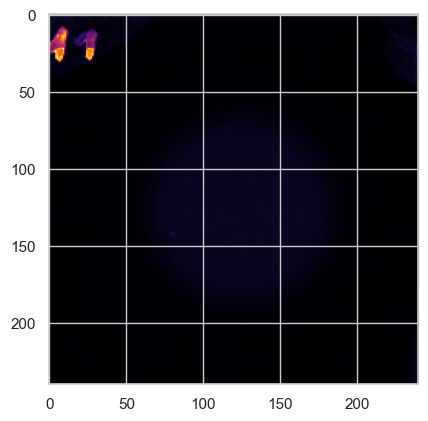

In [14]:
#data = (bg_r - foil_11[:,:,0]) + (bg_g - foil_11[:,:,1]) + (bg_b - foil_11[:,:,2])
data = (13.42539*np.log10(bg_g/foil_11[:,:,1])+61.67447*np.log10(bg_g/foil_11[:,:,1])**3)
plt.imshow(data, cmap='inferno')

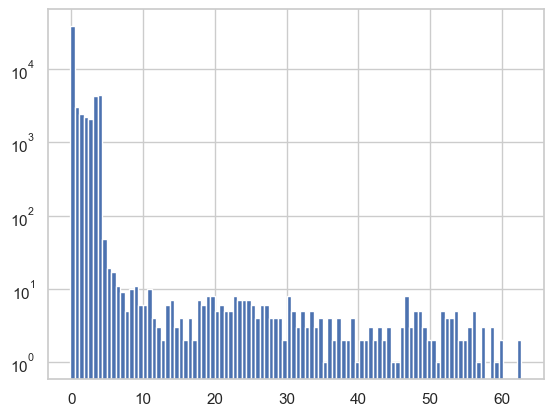

In [15]:
plt.hist(data.flatten(), bins=100);
plt.yscale('log')

In [16]:
data[data<2000].mean()

1.0863584147915883

## Detector cutting

In [17]:
from scipy.ndimage import center_of_mass
cm = center_of_mass(data)
print(f"original data (shape {data.shape}) CM = ({cm[0]:.2f}, {cm[1]:.2f})")

cut_px = 100
data_cut = data[int(cm[0])-cut_px:int(cm[0])+cut_px, int(cm[1])-cut_px:int(cm[1])+cut_px]
cm_cut = center_of_mass(data_cut)
print(f"1st cut data CM = ({cm_cut[0]:.2f}, {cm_cut[1]:.2f}), shape {data_cut.shape}")

cut_px = 95
data_cut = data_cut[int(cm_cut[0])-cut_px:int(cm_cut[0])+cut_px, int(cm_cut[1])-cut_px:int(cm_cut[1])+cut_px]
cm_cut = center_of_mass(data_cut)
print(f"2nd cut data CM = ({cm_cut[0]:.2f}, {cm_cut[1]:.2f}), shape {data_cut.shape}")

cut_px = 80
data_cut = data_cut[int(cm_cut[0])-cut_px:int(cm_cut[0])+cut_px, int(cm_cut[1])-cut_px:int(cm_cut[1])+cut_px]
cm_cut = center_of_mass(data_cut)
print(f"3rd cut data CM = ({cm_cut[0]:.2f}, {cm_cut[1]:.2f}), shape {data_cut.shape}")

# plot center of mass
plt.imshow(data_cut, cmap='gray')
plt.scatter(cm_cut[1], cm_cut[0], color='r');

# Define the center of the image
center_x, center_y = data_cut.shape[0] // 2, data_cut.shape[1] // 2

# Create an array of distances from the center
Y, X = np.ogrid[:data_cut.shape[0], :data_cut.shape[1]]
dist_from_center = np.sqrt((X - cm_cut[0])**2 + (Y - cm_cut[1])**2)

# Select pixels where the distance from center is greater than 80
mask = dist_from_center > 80
selected_pixels = data_cut[mask]

# Calculate the mean of these pixels
mean_value = np.mean(selected_pixels)

data_cut -= mean_value
data_cut.clip(0, None, out=data_cut)

print(f"Mean value of pixels with distance from center > 80: {mean_value:.2f}")

original data (shape (240, 240)) CM = (99.96, 105.24)
1st cut data CM = (nan, nan), shape (0, 200)


/home/grzanka/workspace/osl_mb_foils/.venv/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


ValueError: cannot convert float NaN to integer

In [ ]:
data_cut.shape

In [ ]:
# plot horizontal and vertical profiles
profile_dx = 5
# plot as function of distance in mm, assuming 300dpi
res = 300
y_data = np.mean(data_cut[data_cut.shape[0]//2 - profile_dx//2:data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
y_data_2 = np.mean(data_cut[:, data_cut.shape[1]//2 - profile_dx//2:data_cut.shape[1]//2 + profile_dx//2], axis=1)
x_mm = np.arange(y_data.shape[0]) / res * 25.4
y_data_mean = np.mean(y_data, where=(x_mm>4)&(x_mm<10))
y_data_2_mean = np.mean(y_data_2, where=(x_mm>4)&(x_mm<10))
plt.plot(x_mm, y_data / y_data_mean, color='r')
plt.plot(x_mm, y_data_2 / y_data_mean, color='b')
plt.ylim(0, None)

In [ ]:
dpi = 300
ebt_px_to_mm = 25.4 / dpi
ebt_px_to_mm

# OSL MB

In [ ]:
#det1_im = np.load(Path('C:\\Users\\Legion\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\2024-04-22\\mb_det1.npy'))
det1_im = np.load(project_dir / 'data' / 'raw' / '2024-04-22' / 'mb_det1.npy')

In [ ]:
plt.imshow(det1_im, cmap='gray')

In [ ]:
from scipy.ndimage import center_of_mass
det1_cm = center_of_mass(det1_im)
print(f"original data (shape {data.shape}) CM = ({det1_cm[0]:.2f}, {det1_cm[1]:.2f})")

cut_px = 110
det1_data_cut = det1_im[int(det1_cm[0])-cut_px:int(det1_cm[0])+cut_px, int(det1_cm[1])-cut_px:int(det1_cm[1])+cut_px]
det1_cm_cut = center_of_mass(det1_data_cut)
print(f"1st cut data CM = ({det1_cm_cut[0]:.2f}, {det1_cm_cut[1]:.2f}), shape {det1_data_cut.shape}")

cut_px = 105
det1_data_cut = det1_data_cut[int(det1_cm_cut[0])-cut_px:int(det1_cm_cut[0])+cut_px, int(det1_cm_cut[1])-cut_px:int(det1_cm_cut[1])+cut_px]
det1_cm_cut = center_of_mass(det1_data_cut)
print(f"2nd cut data CM = ({det1_cm_cut[0]:.2f}, {det1_cm_cut[1]:.2f}), shape {det1_data_cut.shape}")

cut_px = 100
det1_data_cut = det1_data_cut[int(det1_cm_cut[0])-cut_px:int(det1_cm_cut[0])+cut_px, int(det1_cm_cut[1])-cut_px:int(det1_cm_cut[1])+cut_px]
det1_cm_cut = center_of_mass(det1_data_cut)
print(f"3rd cut data CM = ({det1_cm_cut[0]:.2f}, {det1_cm_cut[1]:.2f}), shape {det1_data_cut.shape}")

# plot center of mass
plt.imshow(det1_data_cut, cmap='gray')
plt.scatter(det1_cm_cut[1], det1_cm_cut[0], color='r');

In [ ]:
# plot horizontal and vertical profiles
profile_dx = 50
# plot as function of distance in mm, assuming 300dpi
px_to_mm = 0.07211249531663806 
mb_y_data = np.mean(det1_data_cut[det1_data_cut.shape[0]//2 - profile_dx//2:det1_data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
mb_y_data_2 = np.mean(det1_data_cut[:, det1_data_cut.shape[1]//2 - profile_dx//2:det1_data_cut.shape[1]//2 + profile_dx//2], axis=1)
mb_x_mm = np.arange(mb_y_data.shape[0]) * px_to_mm
mb_y_data_mean = np.mean(mb_y_data, where=(mb_x_mm>4)&(mb_x_mm<10))
mb_y_data_2_mean = np.mean(mb_y_data_2, where=(mb_x_mm>4)&(mb_x_mm<10))
plt.plot(mb_x_mm, mb_y_data / mb_y_data_mean, color='r')
plt.plot(mb_x_mm, mb_y_data_2 / mb_y_data_mean, color='b')
plt.ylim(0, None)

# all of them

In [ ]:
plt.plot(x_mm, y_data / y_data_mean, color='g')
#plt.plot(x_mm, y_data_2 / y_data_mean, color='b')
plt.plot(mb_x_mm, mb_y_data / mb_y_data_mean, color='r')
#plt.plot(mb_x_mm, mb_y_data_2 / mb_y_data_mean, color='b')
plt.ylim(0, None)

In [ ]:
plt.plot(x_mm, y_data / y_data_mean, color='g')
# apply median filter on mb_y_data
mb_y_data_filtered = ndi.median_filter(mb_y_data, size=15)
plt.plot(mb_x_mm, mb_y_data_filtered / mb_y_data_mean, color='r')
plt.ylim(0, None)

## EBT3 radial profile

In [ ]:
plt.imshow(data_cut, cmap='viridis')
plt.scatter(cm_cut[1], cm_cut[0], color='r');

In [ ]:
r = []
v = []
for i in range(data_cut.shape[0]):
    for j in range(data_cut.shape[1]):
        v_to_cm = ((i - cm_cut[0])**2 + (j - cm_cut[1])**2)**0.5
        r.append(v_to_cm)
        v.append(data_cut[i, j])
df_r = pd.DataFrame({'r': r, 'v': v})
df_r['r_mm'] = df_r['r'] * ebt_px_to_mm 
df_r['r_mm_round'] = df_r['r_mm'].round(2)
df_r['v_norm'] = df_r['v'] / df_r['v'][df_r['r_mm'] < 3].mean()
df_r


In [ ]:
df_r.plot(x='r_mm_round', y='v', kind='scatter')

In [ ]:
df_r.groupby('r_mm_round').mean().plot(y='v')

## MB radial profile

In [ ]:
plt.imshow(det1_data_cut, cmap='viridis')
plt.scatter(det1_cm_cut[1], det1_cm_cut[0], color='r');

In [ ]:
r = []
v = []
for i in range(det1_data_cut.shape[0]):
    for j in range(det1_data_cut.shape[1]):
        v_to_cm = ((i - det1_cm_cut[0])**2 + (j - det1_cm_cut[1])**2)**0.5
        r.append(v_to_cm)
        v.append(det1_data_cut[i, j])
df_r_mb = pd.DataFrame({'r': r, 'v': v})
df_r_mb['r_mm'] = df_r_mb['r'] * px_to_mm 
df_r_mb['r_mm_round'] = df_r_mb['r_mm'].round(2)
df_r_mb['v_norm'] = df_r_mb['v'] / df_r_mb['v'][df_r_mb['r_mm'] < 3].mean()
df_r_mb


In [ ]:
df_r_mb.plot(x='r_mm_round', y='v_norm', kind='scatter')

In [ ]:
df_r_mb.groupby('r_mm_round').mean().plot(y='v_norm')

# OSL vs MB profile

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df_r_mb.groupby('r_mm_round').mean().plot(y='v_norm', ax=ax, label='MB')
df_r.groupby('r_mm_round').mean().plot(y='v_norm', ax=ax, label='EBT')
plt.xlabel('r [mm]')
plt.ylim(0, 1.2)